# 4. Classification with Convolutional Neural Network

After preprocessing from script 2 we used keras and tensorflow to build CNN.
First we removed duplicates from preprocessed data. Then we created target variable.
In the next step we created tokenizer with max_words = 5000 (max_words is the maximum words in vocabulary) and used pad_sequence for padding to length=200.<br>
After train-test split (the same seed like in previous script with classic ML) we created CNN model for sentiment classification. Then evaluated with ROC and confusion matrix.


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
from seaborn import heatmap
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.models import Sequential
import keras
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras import regularizers

from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [3]:
# read preprocessed and labeled data
df = pd.read_csv('/content/drive/MyDrive/ZUM_NLP/tweets_data_labeled_prepro.csv', index_col=False)
df.drop(['Unnamed: 0','index','text'], axis=1, inplace=True)
df

,sentiments_val,text_prep
0,neutral,coronavirus dotrze polski napotka opor znakomi...
1,positive,kolejni polacy chca wrocic wuhan
2,negative,tymczasem wuhan odcieto reszty swiata obszar p...
3,positive,zdziwie powiedza listy pojechały chin wuhan od...
4,positive,polakow chce wrocic wuhan ambasadzie rp pekini...
...,...,...
456911,negative,piatek maja punkt szczepien powszechnych ul no...
456912,neutral,przyjdz porozmawiaj dowiedz wiecej szczepieniu...
456913,neutral,serio chca wprowadzic prace zdalna wymiarze dn...
456914,negative,szczepienia przeciw covid organizowane szkołac...


In [4]:
# Check if there are missing values or duplicates. If so, we remove them.
print(df.isnull().sum())
df.dropna(inplace=True)

print('Number of duplicates:', df.duplicated().sum())
df.drop_duplicates()

df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)

sentiments_val       0
text_prep         3015
dtype: int64
Number of duplicates: 52188


In [5]:
# create target variable
labels_matrix = np.array(df['sentiments_val'])
y = []
for i in range(len(labels_matrix)):
    if labels_matrix[i] == "negative":
        y.append(0)
    if labels_matrix[i] == "neutral":
        y.append(1)
    if labels_matrix[i] == "positive":
        y.append(2)
y = np.array(y)
labels_matrix = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

labels_matrix

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [6]:
# tokenization and padding
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text_prep'])
sequences = tokenizer.texts_to_sequences(df['text_prep'])
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ... 1013  352   15]
 [   0    0    0 ...  202 1475   39]
 [   0    0    0 ... 3681  215 1910]
 ...
 [   0    0    0 ...    1 1091   50]
 [   0    0    0 ... 1260  117   24]
 [   0    0    0 ... 2222  945 1776]]


In [7]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(tweets, labels_matrix, test_size = 0.15, random_state=24) # the same seed like in script_3

In [ ]:
# --- FIRST APPROACH ---
# With two convolution layers. Also with small regularization.

# CNN model architecture
CNN_model = Sequential()
CNN_model.add(layers.Embedding(max_words, 40, input_length=max_len))
CNN_model.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.004),bias_regularizer=regularizers.l2(0.003)))
CNN_model.add(layers.MaxPooling1D(5))
CNN_model.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.003),bias_regularizer=regularizers.l2(0.003)))
CNN_model.add(layers.GlobalMaxPooling1D())
CNN_model.add(layers.Dense(3,activation='softmax'))
CNN_model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 40)           200000    
                                                                 
 conv1d_2 (Conv1D)           (None, 195, 20)           4820      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 20)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 34, 20)            2420      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 3)                

In [ ]:
# train CNN
history = CNN_model.fit(X_train, 
                     y_train, 
                     epochs=25,
                     validation_data=(X_test, y_test),
                     verbose=1)

# not a big difference between 1 and 25 epoch on test

Epoch 1/25
12057/12057 [==============================] - 111s 9ms/step - loss: 0.6848 - acc: 0.7121 - val_loss: 0.6101 - val_acc: 0.7447
Epoch 2/25
12057/12057 [==============================] - 109s 9ms/step - loss: 0.5951 - acc: 0.7525 - val_loss: 0.5938 - val_acc: 0.7520
Epoch 3/25
12057/12057 [==============================] - 103s 9ms/step - loss: 0.5853 - acc: 0.7557 - val_loss: 0.5881 - val_acc: 0.7528
Epoch 4/25
12057/12057 [==============================] - 107s 9ms/step - loss: 0.5743 - acc: 0.7563 - val_loss: 0.5748 - val_acc: 0.7528
Epoch 5/25
12057/12057 [==============================] - 105s 9ms/step - loss: 0.5634 - acc: 0.7589 - val_loss: 0.5680 - val_acc: 0.7525
Epoch 6/25
12057/12057 [==============================] - 103s 9ms/step - loss: 0.5591 - acc: 0.7608 - val_loss: 0.5916 - val_acc: 0.7440
Epoch 7/25
12057/12057 [==============================] - 107s 9ms/step - loss: 0.5564 - acc: 0.7622 - val_loss: 0.5687 - val_acc: 0.7534
Epoch 8/25
12057/12057 [==========

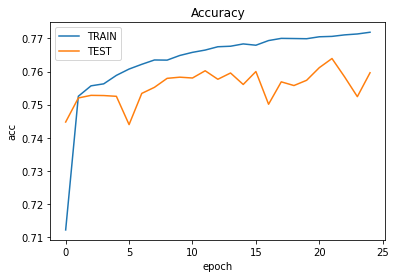

In [ ]:
# plot accuracy for each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')
plt.show()

In [13]:
# --- SECOND APPROACH ---
# more convolution layers, less number of epochs

# CNN model architecture
CNN_model = Sequential()
CNN_model.add(layers.Embedding(max_words, 40, input_length=max_len))
CNN_model.add(layers.Conv1D(20, 9, activation='relu'))
CNN_model.add(layers.MaxPooling1D(4))
CNN_model.add(layers.Conv1D(15, 7, activation='relu'))
CNN_model.add(layers.MaxPooling1D(3))
CNN_model.add(layers.Conv1D(10, 5, activation='relu'))
CNN_model.add(layers.MaxPooling1D(2))
CNN_model.add(layers.Conv1D(5, 5, activation='relu'))
CNN_model.add(layers.GlobalMaxPooling1D())
CNN_model.add(layers.Dense(3,activation='softmax'))
CNN_model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 40)           200000    
                                                                 
 conv1d_10 (Conv1D)          (None, 192, 20)           7220      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 48, 20)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 42, 15)            2115      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 14, 15)           0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 10, 10)           

In [14]:
# train CNN
history = CNN_model.fit(X_train, 
                     y_train, 
                     epochs=5,
                     validation_data=(X_test, y_test),
                     verbose=1)

# better results than before

Epoch 1/5
12057/12057 [==============================] - 121s 10ms/step - loss: 0.6454 - acc: 0.7237 - val_loss: 0.5432 - val_acc: 0.7646
Epoch 2/5
12057/12057 [==============================] - 119s 10ms/step - loss: 0.5311 - acc: 0.7682 - val_loss: 0.5306 - val_acc: 0.7679
Epoch 3/5
12057/12057 [==============================] - 118s 10ms/step - loss: 0.5076 - acc: 0.7742 - val_loss: 0.5206 - val_acc: 0.7626
Epoch 4/5
12057/12057 [==============================] - 119s 10ms/step - loss: 0.4968 - acc: 0.7784 - val_loss: 0.5085 - val_acc: 0.7704
Epoch 5/5
12057/12057 [==============================] - 122s 10ms/step - loss: 0.4924 - acc: 0.7811 - val_loss: 0.5222 - val_acc: 0.7691


In [19]:
# Save the model
CNN_model.save('/content/drive/MyDrive/ZUM_NLP/CNN_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ZUM_NLP/CNN_model/assets


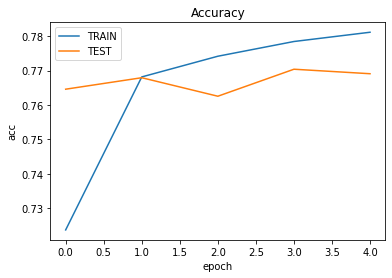

In [15]:
# plot accuracy for each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')
plt.show()

In [16]:
# predictions and confusion matrix
preds = CNN_model.predict(X_test)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1), normalize='true')

In [17]:
def plot_multiROC(pred_prob):
    fpr = {}
    tpr = {}
    thresh ={}

    for i in range(3):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test.argmax(axis=1), pred_prob[:,i], pos_label=i)
        
    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()

def plot_conf_matrix(conf_matrix):
    heatmap(conf_matrix, annot=True, xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
    plt.title('Confusion Matrix for CNN')
    plt.xlabel('PREDICTED')
    plt.ylabel('TRUE')
    plt.show()

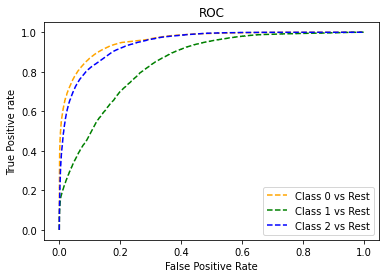

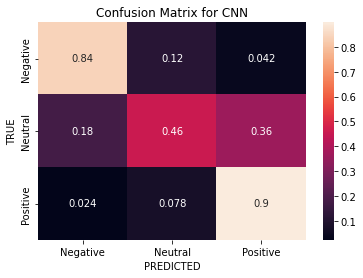

In [18]:
plot_multiROC(pred_prob = preds)
plot_conf_matrix(conf_matrix = conf_matrix)